In [451]:
from matplotlib import pyplot as plt
import numpy as np
import random
import math
import chess
import chess.svg

In [452]:
'''Parámetros de entrada

tamaño_poblacion = int(input("Tamaño de la población: "))
porcentaje_padres = int(input("Porcentaje de padres: "))
porcentaje_cruza = int(input("Porcentaje de cruza: "))
porcentaje_mutacion = int(input("Porcentaje de mutación: "))
evaluacion_limite = int(input("Número de evaluaciones: "))
'''

'Parámetros de entrada\n\ntamaño_poblacion = int(input("Tamaño de la población: "))\nporcentaje_padres = int(input("Porcentaje de padres: "))\nporcentaje_cruza = int(input("Porcentaje de cruza: "))\nporcentaje_mutacion = int(input("Porcentaje de mutación: "))\nevaluacion_limite = int(input("Número de evaluaciones: "))\n'

In [453]:
numero = int(input("numero "))

In [454]:
tamaño_poblacion = int(100)
porcentaje_padres = int(20)
porcentaje_cruza = int(100)
porcentaje_mutacion = int(50)
evaluacion_limite = int(1000)

In [455]:
''' Función que evalúa la aptitud de una solución
    E: solución <- Matriz de un tablero
    S: aptitud <- Aptitud de la solución dada
'''
def calcularAptitud(solucion):
    reinas_fils = 0
    reinas_cols = 0
    reinas_diag = 0
    for fila in range(solucion.shape[0]):
        if (np.sum(solucion[fila,:]) > 1):
            reinas_fils += np.sum(solucion[fila,:]) - 1
    for col in range(solucion.shape[1]):
        if (np.sum(solucion[:,col]) > 1):
            reinas_cols += np.sum(solucion[:,col]) - 1
    for i in range(-7,7):
        if (np.trace(solucion, i) > 1):
            reinas_diag += np.trace(solucion, i) - 1
        if (np.trace(np.rot90(solucion), -i) > 1):
            reinas_diag += np.trace(np.rot90(solucion), -i) - 1        
    return int(reinas_fils+reinas_cols+reinas_diag)


In [456]:
''' Función que genera la población inicial
    E: tamaño <- Tamaño de la población
    S: poblacio, aptitudes <- Lista de soluciones y su aptitud correspondiente  
'''
def generarPoblacion(tamaño):
    poblacion = []
    aptitudes = []
    for index in range (0,tamaño):
        solucion = np.zeros(64)
        pos_reinas = random.sample(range(0, 64), 8)
        for pos in pos_reinas:
            solucion[pos] = 1
        solucion = solucion.reshape((8,8))
        aptitud = calcularAptitud(solucion)
        aptitudes.append((index,aptitud))
        poblacion.append(solucion)
    return poblacion, aptitudes

In [457]:
''' Función que selecciona un porcentaje de la población
    E: poblacion,aptitudes,porcentaje
    S: padres <- Lista de soluciones padre  
'''
def seleccionarPadres(poblacion, aptitudes, porcentaje):
    no_padres = int((tamaño_poblacion*porcentaje)/100)
    if ((no_padres % 2) != 0):
        no_padres+=1
    padres = []
    aptitudes.sort(key=lambda a: a[1])
    i=0
    while i < no_padres:
        p = np.random.uniform(0,1)
        if (p < 0.6):
            pos = random.sample(range(0, math.ceil(tamaño_poblacion/3)), 1)
        elif (p > 0.6) & (p < 0.9):
            pos = random.sample(range(math.ceil(tamaño_poblacion/3), 2*math.ceil(tamaño_poblacion/3)), 1)
        elif (p > 0.9):
            pos = random.sample(range(2*math.ceil(tamaño_poblacion/3), tamaño_poblacion), 1)
        aptitud = aptitudes[pos[0]]
        indice = aptitud[0]
        padres.append(poblacion[indice])
        i+=1
    return padres

In [458]:
def operadorCruza(solucion1, solucion2):    
    first_half1  = solucion1[:,:4]
    second_half1 = solucion1[:,4:]
    first_half2  = solucion2[:,:4]
    second_half2 = solucion2[:,4:]
    sol_1 = np.concatenate((first_half1,second_half2),axis=1)
    sol_2 = np.concatenate((first_half2,second_half1),axis=1)
    return sol_1, sol_2

In [459]:
def getRandomElement(solution, queen):
    if (queen == True):
        indxs = np.where(solution == 1)
    else:
        indxs = np.where(solution == 0)
    rows = indxs[0]
    cols = indxs[1]
    idx = random.randint(0, len(rows)-1)
    return rows[idx], cols[idx]

def repairBoard(solution):
    _, counts = np.unique(solution, return_counts=True)
    while (counts[1] > 8):
        row, col = getRandomElement(solution, queen=True)
        solution[row][col] = 0
        _, counts = np.unique(solution, return_counts=True)
    while (counts[1] < 8):
        row, col = getRandomElement(solution, queen=False)
        solution[row][col] = 1
        _, counts = np.unique(solution, return_counts=True)
    return solution

In [460]:
def mutateBoard(solution):
    row_a, col_a = getRandomElement(solution, queen=True)
    row_b, col_b = getRandomElement(solution, queen=False)
    solution[row_a][col_a] = 0
    solution[row_b][col_b] = 1
    return solution

In [461]:
# Inicializar población
ppl, appts = generarPoblacion(tamaño_poblacion)
best_fitness = []
best_average = []
best_solution = 0
flag = False
for count in range(evaluacion_limite):
    # Cruzar padres y reparar hijos
    ppdrs = seleccionarPadres(ppl, appts, porcentaje_padres)
    hhjs = []    
    no_cruzadores = int((len(ppdrs*porcentaje_cruza)/100))
    if ((no_cruzadores % 2) != 0):
        no_cruzadores+=1
    pares = list(range(0, no_cruzadores, 2))
    for i in pares:
        hijo1, hijo2 = operadorCruza(ppdrs[i], ppdrs[i+1])
        hijo1 = repairBoard(hijo1)
        hijo2 = repairBoard(hijo2)
        hhjs.append(hijo1)
        hhjs.append(hijo2)

    # Mutar hijos
    no_mutados = int((len(hhjs*porcentaje_mutacion)/100))
    for i in range(no_mutados):
        hhjs[i] = mutateBoard(hhjs[i])

    # Actualizar población
    ppl = ppl + hhjs
    nuevas_apptitudes = []
    nueva_poblacion = []
    for index in range(len(ppl)):
            aptitud = calcularAptitud(ppl[index])
            nuevas_apptitudes.append((index,aptitud))
    nuevas_apptitudes.sort(key=lambda a: a[1])
    appts = nuevas_apptitudes[:tamaño_poblacion] 

    for i in appts:
        nueva_poblacion.append(ppl[i[0]])
    ppl = nueva_poblacion

    nuevas_apptitudes.clear()
    average_fit = 0
    for index in range(len(ppl)):
            aptitud = calcularAptitud(ppl[index])
            average_fit += aptitud
            nuevas_apptitudes.append((index,aptitud))
    appts = nuevas_apptitudes
    average_fit = average_fit/tamaño_poblacion
    best_fitness.append(appts[0][1])
    best_average.append(average_fit)
    if (appts[0][1] == 0) and (flag == False):
        best_solution = count+1
        break

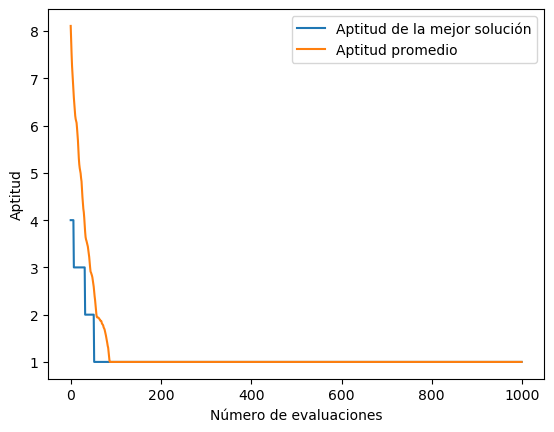

In [462]:
plt.plot(best_fitness, label='Aptitud de la mejor solución')
plt.plot(best_average, label='Aptitud promedio')

plt.xlabel("Número de evaluaciones")
plt.ylabel("Aptitud")
plt.legend() 
plt.savefig(str(numero) + '_plot.png')

In [463]:
print("Tamaño de la población: ", tamaño_poblacion)
print("Porcentaje de padres: ", porcentaje_padres)
print("Porcentaje de cruza: ", porcentaje_cruza)
print("Porcentaje de mutación: ", porcentaje_mutacion)
print("Número de evaluaciones límite: ", evaluacion_limite)
print("Evaluaciones necesarias: ", best_solution)

Tamaño de la población:  100
Porcentaje de padres:  20
Porcentaje de cruza:  100
Porcentaje de mutación:  50
Número de evaluaciones límite:  1000
Evaluaciones necesarias:  0


In [464]:
def fenCode(solution):
    fen = ''
    for i in range(8):
        count = 0
        i_row = ''
        for j in range(8):
            if (solution[i,j] == 1):
                i_row += str(count)
                i_row += 'Q'
                count = 0
            else:
                count += 1
        i_row += str(count)
        fen += '/' + i_row
    fen = fen.replace('0', '')
    return fen[1:]

In [465]:
solution = ppl[0].astype(int)
fen = fenCode(solution)
board = chess.Board(fen)
boardsvg = chess.svg.board(board=board, size=350)
outputfile = open(str(numero) + '_board.svg', "w")
outputfile.write(boardsvg)
outputfile.close()